## Histopathologic Cancer Detection

В этом соревновании создаю алгоритм для выявления метастатического рака на небольших участках изображения, взятых из больших цифровых сканирований патологии (см. изображение). https://www.kaggle.com/c/histopathologic-cancer-detection В коде я использую претринерованую нейросеть ResNet.

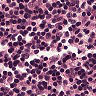

In [35]:
Image.open('../input/histopathologic-cancer-detection/train/0000f8a4da4c286eee5cf1b0d2ab82f979989f7b.tif')

In [36]:
from typing import List
import logging
from typing import Optional
from functools import partial
from typing import Tuple
from typing import Union


import torch.nn as nn
import numpy as np
import os
import pandas as pd
import torch
from torch.optim import Adam
from torchvision.models.resnet import BasicBlock
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from PIL import Image
from matplotlib import pyplot as plt
from torchvision.models.resnet import ResNet
from sklearn.metrics import roc_auc_score
from torch import Tensor
from torchvision import transforms
from torch.autograd import Variable

In [37]:
DATA_FOLDER = '../input/histopathologic-cancer-detection'
LABELS = f'{DATA_FOLDER}/train_labels.csv'
TRAIN_IMAGES_FOLDER = f'{DATA_FOLDER}/train'
SAMPLE_SUBMISSION = f'{DATA_FOLDER}/sample_submission.csv'
USE_GPU = torch.cuda.is_available()

In [38]:
logging.basicConfig(level='INFO')
logger = logging.getLogger()

In [39]:
pd.read_csv(LABELS).shape

(220025, 2)

In [40]:
# Метод для конвертации дата фрейма ответов в нумпай массив для дата лоудера
def format_labels_for_data_set(labels: pd.DataFrame) -> np.array:
    return (labels['label'].values.reshape(-1,1))

# Сплит train на тренировочную и валидационную выборки
def train_valid_split(df: pd.DataFrame, split_percent: int) -> Tuple:
    limit_df = 100000
    df = df.sample(n = df.shape[0])
    df = df.iloc[:limit_df]
    split = round(limit_df * split_percent / 100)
    train = df.iloc[:split]
    valid = df.iloc[split:]
    return (train, valid)

# возвращает полный путь к картинкам из labels sample
def format_path_to_images_for_dataset(labels: pd.DataFrame, path: str) -> List:
    return [os.path.join(path, f'{f}.tif') for f in labels['id'].values]

STEP 1 - DATASETS

In [41]:
# класс, в котором определяется исходный DataSet и делается масштабирование исходных данных
class MainDataset(Dataset):
    def __init__(self, x_dataset: Dataset, y_dataset: Dataset, x_tfms: Optional = None):
        self.x_dataset = x_dataset
        self.y_dataset = y_dataset
        self.x_tfms = x_tfms
        
    def __len__(self) -> int:
        return self.x_dataset.__len__() 
        
    def __getitem__(self, index: int) -> Tuple:
        x = self.x_dataset[index]
        y = self.y_dataset[index]
        if x_tfms is not None:
            x = self.x_tfms(x)
        return x, y

# возвращает картинку (с учетом ее полного пути) по индексу
class ImageDataset(Dataset):
    def __init__(self, path_to_image: List):
        self.path_to_image = path_to_image
    
    def __len__(self) -> int:
        return len(self.path_to_image)
    
    def __getitem__(self, index: int) -> Image.Image:
        img = Image.open(self.path_to_image[index])
        return img


# возвращает label по индексу
class LabelDataset(Dataset):
    def __init__(self, labels: List):
        self.labels = labels
    
    def __len__(self) -> int:
        return len(labels)
    
    def __getitem__(self, index:int) -> int:
        return self.labels[index]


In [42]:
labels = pd.read_csv(LABELS)
sample_submission = pd.read_csv(SAMPLE_SUBMISSION)

train, valid = train_valid_split(labels, 70)

train_labels = format_labels_for_data_set(train)
valid_labels = format_labels_for_data_set(valid)

train_images = format_path_to_images_for_dataset(train, TRAIN_IMAGES_FOLDER)
valid_images = format_path_to_images_for_dataset(valid, TRAIN_IMAGES_FOLDER)

train_images_dataset = ImageDataset(train_images)
valid_images_dataset = ImageDataset(valid_images)
train_labels_dataset = LabelDataset(train_labels)
valid_labels_dataset = LabelDataset(valid_labels)


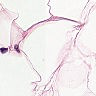

In [43]:
train_images_dataset[5]

STEP 2 - TRANSFORMERS

In [44]:
# зададим форматирование и перевод в тензорный вид наших тренировочных данных 
x_tfms = transforms.Compose([transforms.ToTensor(), 
                             transforms.Normalize(
                                 mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]
                             )
                            ])

In [45]:
# определим объеккты из данных и ответов для загрузки в data loader
train_dataset = MainDataset(train_images_dataset, train_labels_dataset, x_tfms)
valid_dataset = MainDataset(valid_images_dataset, valid_labels_dataset, x_tfms)

STEP 3 - DATALOADER

In [46]:
# загружаем данные в data loader, определяем число батчей
shuffle = True
batch_size = 512
num_workers = 0

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = shuffle, num_workers = num_workers)
valid_dataloader = DataLoader(valid_dataset, batch_size = batch_size, shuffle = shuffle, num_workers = num_workers)

STEP 4 - MODEL

In [47]:
# запустим процессы на видеокарте

def to_gpu(tensor):
    return tensor.cuda() if USE_GPU else tensor

# Инициализируем слои в нейросети вида ResNet c 9-ю слоями
def create_resnet9_model(output_dim: int = 1) -> nn.Module:
    model = ResNet(BasicBlock, [1, 1, 1, 1])
    # размер входящей картинки
    in_features = model.fc.in_features
    # output size = 1X1
    model.avgpool = nn.AdaptiveAvgPool2d(1)
    model.fc = nn.Linear(in_features, output_dim)
    model = to_gpu(model)
    return model



In [48]:
# создадим инстанс архитектуры
resnet9 = create_resnet9_model()
resnet9

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

STEP 5 - OPTIMIZER

In [49]:
# зададим метод спуска для весов, обозначим learning rate
lr = 1e-3
optimizer = Adam(resnet9.parameters(), lr)

STEP 6 - LOSS

In [50]:
# зададим функцию потерь, которую будем оптимизировать - бинарная кроссэнтропия с вычислением сигмоиды от ответов
loss = nn.BCEWithLogitsLoss()

STEP 7 - TRAINER / PREDICTOR / TRIGGERS

In [51]:
#тренировка данных
#будем считать на каждой итерации roc_auc_score на трейне и на тесте, и выводить в логи
def auc_writer(y_true, y_predicted, iteration):
    try:
        score = roc_auc_score(np.vstack(y_true), np.vstack(y_predicted))
    except:
        score = -1
    print(f'iteration: {iteration}, roc_auc: {score}')
    logger.info(f'iteration: {iteration}, roc_auc: {score}')    
    
loss_writer_train = auc_writer
loss_writer_valid = auc_writer

In [52]:
# определим функцию, с помощью которой мы будем делать предсказания на test-e. Переведем сначала данные в Variable, 
#а затем предсказания в numpy
def predict(model, dataloader):
    model.eval()
    y_true, y_hat = [], []
    
    for x, y in dataloader:
        x = Variable(T(x))
        y = Variable(T(y))
        output = model(x)
        
        y_true.append(to_numpy(y))
        y_hat.append(to_numpy(output))
    
    return y_true, y_hat

In [53]:
# Напишем метод преобразования данных в FloatTensor и переместим на GPU 
def T(tensor):
    if not torch.is_tensor(tensor):
        tensor = torch.FloatTensor(tensor)
    else:
        tensor = tensor.type(torch.FloatTensor)
    if USE_GPU:
        tensor = to_gpu(tensor)
    return tensor

# Напишем метод преобразования данных в numpy и перенос их с GPU на CPU
def to_numpy(tensor):
    if type(tensor) == np.array or type(tensor) == np.ndarray:
        return np.array(tensor)
    elif type(tensor) == Image.Image:
        return np.array(tensor)
    elif type(tensor) == Tensor:
        return tensor.cpu().detach().numpy()
    else:
        raise ValueError(msg)

In [54]:
# мы хотим делать шаг в сторону антиграниента на optimizer каждую итерацию, считать roc-auc на трейне на каждой 10-ой итерации,
# на valid на каждой 20-ой итерациии Обозначим эти шаги

def iteration_trigger(iteration, every_x_iteration):
    if every_x_iteration == 1:
        return True
    elif iteration > 0 and iteration % every_x_iteration == 0:
        return True
    else:
        return False
    
# иницилизируем стоп тригеры на желаемой итерации, зададим также дефолтные значения функции

def init_triggers(step = 1, train = 10, valid = 10):
    do_step_trigger = partial(iteration_trigger, every_x_iteration = step)
    train_loss_trigger = partial(iteration_trigger, every_x_iteration = train)
    valid_loss_trigger = partial(iteration_trigger, every_x_iteration = valid)
    
    return do_step_trigger, train_loss_trigger, valid_loss_trigger

# вызовем предыдущую функцию, задав нужные нам триггеры

do_step_trigger, train_loss_trigger, valid_loss_trigger = init_triggers(1, 10, 20)

In [55]:
# зададим последовательность действий для тренировки сети на данных в рамках одной эпохи

def train_one_epoch(model, 
                    train_data_loader, 
                    valid_data_loader, 
                    loss, 
                    optimizer, 
                    loss_writer_train, 
                    loss_writer_valid,
                    do_step_trigger,
                    train_loss_trigger,
                    valid_loss_trigger):
    
    y_true_train, y_hat_train = [], []
    for iteration, (x, y) in enumerate(train_data_loader):
        x_train = Variable(T(x), requires_grad = True)
        y_train = Variable(T(y), requires_grad = True)
        
        output = model(x_train)
        y_true_train.append(to_numpy(y_train))
        y_hat_train.append(to_numpy(output))
        loss_values = loss(output, y_train)
        loss_values.backward()
        
        #делаем шаг на каждой итерации и сбрасываем градиент
        if do_step_trigger(iteration):
            optimizer.step()
            optimizer.zero_grad()
        
        # проверяем, если итерация кратна train_step = 10, то тогда записываем в лог значение roc_auc
        if train_loss_trigger(iteration):
            print('train_loss_trigger: ')
            loss_writer_train(y_true_train, y_hat_train, iteration)
            y_true_train, y_hat_train = [], []
        
        # проверяем, если итерация кратна valid_step = 20, то тогда записываем в лог значение roc_auc
        if valid_loss_trigger(iteration):
            print('valid_loss_trigger:')
            y_true_valid, y_hat_valid = predict(model, valid_data_loader)
            loss_writer_valid(y_true_valid, y_hat_valid, iteration)
        
    return model

In [ ]:
# обучим наши данные на одной эпохе
resnet9 = train_one_epoch(resnet9, 
                    train_dataloader, 
                    valid_dataloader, 
                    loss, 
                    optimizer, 
                    loss_writer_train, 
                    loss_writer_valid,
                    do_step_trigger,
                    train_loss_trigger,
                    valid_loss_trigger)

train_loss_trigger: 
iteration: 10, roc_auc: 0.7971358661784937
train_loss_trigger: 
iteration: 20, roc_auc: 0.8691516211976935
valid_loss_trigger:
iteration: 20, roc_auc: 0.8271175403831822
train_loss_trigger: 
iteration: 30, roc_auc: 0.7076508750448816
train_loss_trigger: 
iteration: 40, roc_auc: 0.8233074419613798
valid_loss_trigger:
iteration: 40, roc_auc: 0.8524489847402108
train_loss_trigger: 
iteration: 50, roc_auc: 0.8502295421400292
train_loss_trigger: 
iteration: 60, roc_auc: 0.8591061471966017
valid_loss_trigger:
iteration: 60, roc_auc: 0.8705138627432425
train_loss_trigger: 
iteration: 70, roc_auc: 0.868066064055351
train_loss_trigger: 
iteration: 80, roc_auc: 0.8839103052224127
valid_loss_trigger:


STEP 8 - TEST PREDICTIONS 

In [ ]:
TEST_IMAGES_FOLDER = f'{DATA_FOLDER}/test/'

# преобразуем исходные данные сначала в Image, затем в Tensor

#сделаем функцию, которая возвращает список названий картинок в папке test
def test_image_collection(directory: str) -> List:
    images_name = []
    for filename in os.listdir(directory):
        images_name.append(TEST_IMAGES_FOLDER + filename)
    return(images_name)

test_image = test_image_collection(TEST_IMAGES_FOLDER)
test_images_dataset = ImageDataset(test_image)    

# зададим форматирование и перевод в тензорный вид наших тестовых данных 
class TestDataset(Dataset):
    def __init__(self, x_dataset: Dataset, x_tfms: Optional = None):
        self.x_dataset = x_dataset
        self.x_tfms = x_tfms
        
    def __len__(self) -> int:
        return self.x_dataset.__len__() 
        
    def __getitem__(self, index: int) -> Tuple:
        x = self.x_dataset[index]
        if x_tfms is not None:
            x = self.x_tfms(x)
        return x
    
test_dataset = TestDataset(test_images_dataset, x_tfms)    

# загружаем данные в data loader, определяем число батчей
batch_size = 512
num_workers = 0
shuffle = False

test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = shuffle, num_workers = num_workers)

In [ ]:
# определим функцию предсказания для тестовой выборки
def predict_test(model, dataloader):
    model.eval()
    y_hat = []
    
    for x in dataloader:
        x = Variable(T(x))
        output = model(x)
        
        y_hat.append(to_numpy(output))
    return y_hat

In [ ]:
# сделаем предсказания для тестовой выборки
y_hat_test = predict_test(resnet9, test_dataloader)

In [ ]:
# запишем ответы в DataFrame
predictions = pd.DataFrame(
    list(
        zip(
            test_image,
            np.vstack(y_hat_test).reshape(-1)
        )
    ), 
     columns=['id', 'label'])
predictions['id'] = predictions['id'].apply(lambda x: x.split('/')[-1].split('.')[0]) 

In [ ]:
predictions.to_csv('submission.csv', index=False)

In [ ]:
predictions